In [1]:
import pandas as pd
import numpy as np
from time import time

In [2]:
okc = pd.read_csv('../Assets/A/one_long_essay.csv', index_col='Unnamed: 0')

In [3]:
def denull(essay):
    if type(essay) == float:
        return ''
    else: return essay
    
okc.essays = okc.essays.apply(denull)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
t0 = time()
vec = TfidfVectorizer(encoding='utf-8', stop_words='english', max_features=2000)
tf = vec.fit_transform(okc.essays)
print "vectorized essays in %g seconds" %(time()-t0)

vectorized essays in 16.2227 seconds


In [6]:
tf = pd.DataFrame(tf.toarray(), columns=vec.get_feature_names())

In [7]:
# Save any features we might want to filter by to tf dataframe
features = ['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 
           'height', 'income', 'job', 'offspring', 'orientation', 'pets', 'religion', 
            'sex', 'sign', 'smokes', 'speaks']

In [8]:
for feature in features:
    tf['X%s' %feature] = okc[feature]

In [9]:
# Handle some common conjunctions which get separated from words
# leading to features like 'don' and 'll

tf = tf.rename(columns = {'don':"don't", 'll':"i'll", 've':"i've"})

### Find top words by tf-idf score

In [10]:
mean_words = tf.iloc[:,:2000].mean(axis=0)
mean_words.sort_values(inplace=True, ascending=False)

In [11]:
# add something to this for hue?
mean_words[:60].to_csv('../Assets/Tableau/top_words.csv')

In [12]:
# Save a single string with top words for each category.  This list will be exported to a .txt file at end of script
all_lists = ''

### Compare word frequency for men vs. women

In [13]:
# Compute mean value of each of first 2000 columns for men
t0 = time()
mdf = tf[tf.Xsex=='m']
df = pd.DataFrame(mdf.iloc[:,:2000].mean(axis=0), columns = ['m'])
print time()-t0

0.674036979675


In [14]:
# Compute mean value of each of first 2000 columns for women
t0 = time()
fdf = tf[tf.Xsex == 'f']
df['f'] = fdf.iloc[:,:2000].mean(axis=0)
print time()-t0

0.482522964478


In [15]:
df['diff'] = df['m']-df['f']

In [16]:
df.sort_values('diff', inplace=True)

In [17]:
# Save top 200 words for women and men for report
women_list = ''
for word in df.index[:200]:
    women_list = women_list + word + ', '
    
men_list = ''
# Write men_list in reverse order so most popular words are on top
for i in range(-1, -200, -1):
    men_list = men_list + df.index[i] + ', '
    
all_lists = 'Women \n \n' + women_list + '\n\n Men \n\n' + men_list

In [18]:
# Save top 30 from each cat
# women
df.sort_values('diff', inplace=True)
f = pd.DataFrame(df.head(30)['f'])
f.columns = ['tfidf']
f['label'] = 'female'

# men
df.sort_values('diff', inplace=True, ascending=False)
m = pd.DataFrame(df.head(30)['m'])
m.columns = ['tfidf']
m['label'] = 'male'


df_sex = pd.concat([m, f], axis=0)

df_sex.to_csv('../Assets/Tableau/df_sex.csv')

### Compare word frequency for social drinkers vs. heavy drinkers vs. non drinkers

In [19]:
# Compare word frequency for social drinkers vs. heavy drinkers vs. non drinkers

# Compute mean value of each of first 2000 columns for social drinks
t0 = time()
ddf = tf[tf.Xdrinks=='socially']
df = pd.DataFrame(ddf.iloc[:,:2000].mean(axis=0), columns = ['social'])
print time()-t0

0.851545095444


In [20]:
# Compute mean value of each of first 2000 columns for non-drinkers
t0 = time()
ddf = tf.query("Xdrinks == 'rarely'|Xdrinks == 'not at all'")
df['non-drinker'] = ddf.iloc[:,:2000].mean(axis=0)
print time()-t0

0.359460115433


In [21]:
# Compute mean value of each of first 2000 columns for heavy drinkers
t0 = time()
ddf = tf.query("Xdrinks == 'often'|Xdrinks == 'very often'|Xdrinks == 'desperately'")
df['heavy'] = ddf.iloc[:,:2000].mean(axis=0)
print time()-t0

0.189160823822


In [22]:
df['avg'] = df.mean(axis=1)
# Compute differences between social drinkers' values and other categories
df['nd_diff'] = df['non-drinker'] - df['avg']
df['h_diff'] = df['heavy'] - df['avg']
df['s_diff'] = df['social'] - df['avg']

In [23]:
# Save top 200 words for heavy, social, and non-drinkers for report
# heavy drinkers:
df.sort_values('h_diff', ascending=False, inplace=True)

heavy_list = ''
for word in df.index[:200]:
    heavy_list = heavy_list + word + ', '

# social drinkers:
df.sort_values('s_diff', ascending=False, inplace=True)

social_list = ''
for word in df.index[:200]:
    social_list = social_list + word + ', '
    
# non-drinkers:
df.sort_values('nd_diff', ascending=False, inplace=True)

non_list = ''
for word in df.index[:200]:
    non_list = non_list + word + ', '
    
all_lists = all_lists +  '\n\nDrink heavily \n \n' +  heavy_list + '\n\nDrink socially \n\n' + social_list + '\n\nDo not drink regularly \n\n'+ non_list

In [24]:
# Save top 18 from each cat
# non-drinkers first
df.sort_values('nd_diff', inplace=True, ascending=False)
nd = pd.DataFrame(df.head(18)['non-drinker'])
nd.columns = ['tfidf']
nd['label'] = 'non-drinker'

# social drinkers
df.sort_values('s_diff', inplace=True, ascending=False)
sd = pd.DataFrame(df.head(18)['social'])
sd.columns = ['tfidf']
sd['label'] = 'social'

# heavy drinkers
df.sort_values('h_diff', inplace=True, ascending=False)
hd = pd.DataFrame(df.head(18)['heavy'])
hd.columns = ['tfidf']
hd['label'] = 'heavy'

df_drinks = pd.concat([nd, sd, hd], axis=0)

df_drinks.to_csv('../Assets/Tableau/df_drinks.csv')

### Explore word choice by age

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline

<function matplotlib.pyplot.show>

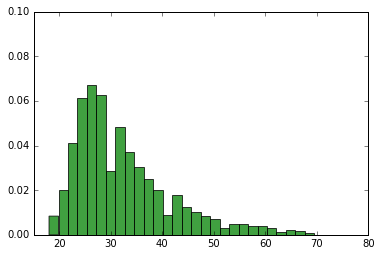

In [26]:
plt.hist(okc.age, 50, normed=1, facecolor='green', alpha=0.75)
plt.axis([15, 80, 0, .1])
plt.show

In [27]:
# Compare under 30 to over 30

def age_encoder(age):
    if age ==0:
        return np.nan
    elif age < 30:
        return 0
    else:
        return 1
    
tf.Xage = tf.Xage.apply(age_encoder)

In [28]:
# Compare word frequency for under 30 vs. over 30

# Compute mean value of each of first 2000 columns for over 30
t0 = time()
odf = tf[tf.Xage==1]
df = pd.DataFrame(odf.iloc[:,:2000].mean(axis=0), columns = ['>30'])
print time()-t0

# Compute mean value of each of first 2000 columns for under 30
ydf = tf[tf.Xage == 0]
df['<30'] = ydf.iloc[:,:2000].mean(axis=0)
print time()-t0


0.699970960617
1.51530790329


In [29]:
df['diff'] = df['>30']-df['<30']
df.sort_values('diff', inplace=True)

In [30]:
# Save top 200 words for people under and over 30
# older people:
df.sort_values('diff', ascending=False, inplace=True)

older_list = ''
for word in df.index[:200]:
    older_list = older_list + word + ', '

# younger people
younger_list = ''
# Write older_list in reverse order so most popular words are on top
for i in range(-1, -200, -1):
    younger_list = younger_list + df.index[i] + ', '
    
all_lists = all_lists + '\n\nOver 30 \n \n' + older_list + '\n\nUnder 30 \n\n' + younger_list

In [31]:
# Save top 30 from each cat
# n.b terms younger and older are strictly relative

# younger
df.sort_values('diff', inplace=True)
y = pd.DataFrame(df.head(30)['<30'])
y.columns = ['tfidf']
y['label'] = '<30'

# older
df.sort_values('diff', inplace=True, ascending=False)
o = pd.DataFrame(df.head(30)['>30'])
o.columns = ['tfidf']
o['label'] = '>30'


df_age = pd.concat([y, o], axis=0)

df_age.to_csv('../Assets/Tableau/df_age.csv')

### Compare drug users and non-users
exclude those who don't report

In [32]:
def drug_encoder(drugs):
    if drugs == 'never':
        return 0
    elif drugs == 'sometimes' or drugs == 'often':
        return 1
    else:
        return np.nan
    
tf.Xdrugs = tf.Xdrugs.apply(drug_encoder)

In [33]:
# Compute mean value of each of first 2000 columns for drug users
t0 = time()
udf = tf[tf.Xdrugs==1]
df = pd.DataFrame(odf.iloc[:,:2000].mean(axis=0), columns = ['users'])
print time()-t0

# Compute mean value of each of first 2000 columns for non-users
ydf = tf[tf.Xdrugs == 0]
df['non-users'] = ydf.iloc[:,:2000].mean(axis=0)
print time()-t0

2.25930714607
2.9483859539


In [34]:
df['diff'] = df['users']-df['non-users']
df.sort_values('diff', inplace=True)

In [35]:
# Save top 200 words for users and non-users
# users:
df.sort_values('diff', ascending=False, inplace=True)

non_user_list = ''
for word in df.index[:200]:
    non_user_list = non_user_list + word + ', '

# non-users
user_list = ''
# Write older_list in reverse order so most popular words are on top
for i in range(-1, -200, -1):
    user_list = user_list + df.index[i] + ', '
    
all_lists = all_lists + '\n\nUse drugs \n \n' + non_user_list + '\n\nDo not use drugs \n\n' + user_list

In [36]:
# Save top 30 from each cat
# non-users

n = pd.DataFrame(df.head(30)['non-users'])
n.columns = ['tfidf']
n['label'] = 'non-users'

# users

m = pd.DataFrame(df.tail(30)['users'])
m.columns = ['tfidf']
m['label'] = 'users'


df_drugs = pd.concat([m, n], axis=0)

df_drugs.to_csv('../Assets/Tableau/df_drugs.csv')

### Explore Income

<function matplotlib.pyplot.show>

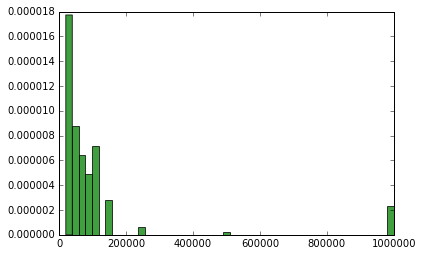

In [37]:
plt.hist(tf.Xincome[tf.Xincome != -1], 50, normed=1, facecolor='green', alpha=0.75)
plt.show

In [38]:
# Divide income income into <50k, 50-100k, >100k

def income_encoder(income):
    if income == -1:
        return -1
    elif income <= 50000:
        return 0
    elif income <= 100000:
        return 1
    else:
        return 2
    
tf.Xincome = tf.Xincome.apply(income_encoder)

In [39]:
# Compare word frequency for different income levels

# Compute mean value of each of first 2000 columns for lower income
t0 = time()
pdf = tf[tf.Xincome==0]
df = pd.DataFrame(pdf.iloc[:,:2000].mean(axis=0), columns = ['<50k'])
print time()-t0

# Compute mean value of each of first 2000 columns for middle income
t0 = time()
mdf = tf[tf.Xincome==1]
df['50-100k'] = mdf.iloc[:,:2000].mean(axis=0)
print time()-t0

# Compute mean value of each of first 2000 columns for highest income
t0 = time()
rdf = tf[tf.Xincome==2]
df['>100k'] = rdf.iloc[:,:2000].mean(axis=0)
print time()-t0


# Compute differences between each income category and overall average
df['avg'] = df.mean(axis=1)
df['r_diff'] = df['>100k'] - df['avg']
df['p_diff'] = df['<50k'] - df['avg']
df['m_diff'] = df['50-100k'] - df['avg']

0.19762301445
0.105547904968
0.0465598106384


In [40]:
# Save lists for each income bracket

df.sort_values('r_diff', ascending=False, inplace=True)

upper_list = ''
for word in df.index[:200]:
    upper_list = upper_list + word + ', '
    
df.sort_values('m_diff', ascending=False, inplace=True)

mid_list = ''
for word in df.index[:200]:
    mid_list = mid_list + word + ', '
    

df.sort_values('p_diff', ascending=False, inplace=True)    
lower_list = ''
for word in df.index[:200]:
    lower_list = lower_list + word + ', '

all_lists = all_lists + '\n\nMake over 100k annually \n \n' + upper_list + '\n\nMake 50-100k annually\n\n' + mid_list+ '\n\nMake less than 50k annually'+lower_list

In [41]:
# Save top 18 from each cat
# richest first
df.sort_values('r_diff', inplace=True, ascending=False)
df2 = pd.DataFrame(df.head(18)['>100k'])
df2.columns = ['tfidf']
df2['label'] = '> 100k'

# middle income
df.sort_values('m_diff', inplace=True, ascending=False)
df3 = pd.DataFrame(df.head(18)['50-100k'])
df3.columns = ['tfidf']
df3['label'] = '50 - 100k'

# lower income
df.sort_values('p_diff', inplace=True, ascending=False)
df4 = pd.DataFrame(df.head(18)['<50k'])
df4.columns = ['tfidf']
df4['label'] = '< 50k'

df_income = pd.concat([df2, df3, df4], axis=0)
df_income.to_csv('../Assets/Tableau/df_income.csv')

### Compare dog and cat people

In [42]:
# calculate dummy columns for likes dogs and likes cats
# will be some overlap since not mutually exclusive

def mask_dogs(pets):
    # catches 'has dogs' or 'likes dogs'
    try:
        if pets.find('dogs') > -1:
            if pets.find('dislikes dogs') == -1:
                return 1
        else:
            return 0
    except:
        return 0
    
def mask_cats(pets):
    try:
        if pets.find('cats') > -1:
            if pets.find('dislikes cats') == -1:
                return 1
        else:
            return 0
    except:
        return 0

tf['Xdogs'] = tf.Xpets.apply(mask_dogs)
tf['Xcats'] = tf.Xpets.apply(mask_cats)

In [43]:
# find mean scores for dog people

t0 = time()
ddf = tf[tf.Xdogs==1]
df = pd.DataFrame(ddf.iloc[:,:2000].mean(axis=0), columns = ['dogs'])
print time()-t0

# find mean scores for cat people
cdf = tf[tf.Xcats == 1]
df['cats'] = cdf.iloc[:,:2000].mean(axis=0)
print time()-t0

2.24761986732
2.73856282234


In [44]:
df['diff'] = df['dogs'] - df['cats']
df.sort_values('diff', inplace=True)

In [45]:
# remove cat, cats, dog and dogs from this list since they don't contribute insight
df = df.drop(['cat', 'cats', 'dog', 'dogs'], axis=0)

In [46]:
# Save top 200 words for cats and dogs for report
cat_list = ''
for word in df.index[:200]:
    cat_list = cat_list + word + ', '
    
dog_list = ''
# Write dog_list in reverse order so most popular words are on top
for i in range(-1, -200, -1):
    dog_list = dog_list + df.index[i] + ', '
    
all_lists = all_lists + '\n\nLike cats\n \n' + cat_list + '\n\nLike dogs \n\n' + dog_list

In [47]:
# Save top 30 from each cat
# cats

n = pd.DataFrame(df.head(30)['cats'])
n.columns = ['tfidf']
n['label'] = 'cats'

# men

m = pd.DataFrame(df.tail(30)['dogs'])
m.columns = ['tfidf']
m['label'] = 'dogs'


df_drugs = pd.concat([m, n], axis=0)

df_drugs.to_csv('../Assets/Tableau/df_pets.csv')

### Explore word choice by education

college grad? 1 or 0.

In [48]:
def ed_encoder(ed):
    # a person is a college grad if they either "graduated from college/university"
    # or mention law school, med, school, masters program or ph. d program (all instances of the word program are graduate )
    try:
        if ed == 'graduated from college/university' or ed.find('law') >= 0 or ed.find('med') >= 0 or ed.find('program') >= 0:
            return 1
        # space camp answers are facetious and must be excluded
        # BTW I am in space camp right now
        elif ed.find('space camp') >= 0:
            return np.nan
        else: return 0
    except:
        return np.nan

tf.Xeducation = tf.Xeducation.apply(ed_encoder)

In [49]:
# Compare word frequency for college educated vs. not college

# Compute mean value of each of first 2000 columns for college
t0 = time()
df2 = tf[tf.Xage==1]
df = pd.DataFrame(df2.iloc[:,:2000].mean(axis=0), columns = ['grad'])
print time()-t0

# Compute mean value of each of first 2000 columns for under 30
df2 = tf[tf.Xage == 0]
df['non-grad'] = df2.iloc[:,:2000].mean(axis=0)
print time()-t0

df['diff'] = df['grad'] - df['non-grad']
df.sort_values('diff', inplace=True)

# Save top 200 words for grads and non-grads for report
non_grad_list = ''
for word in df.index[:200]:
    non_grad_list = non_grad_list + word + ', '
    
grad_list = ''
# Write grad_list in reverse order so most popular words are on top
for i in range(-1, -200, -1):
    grad_list = grad_list + df.index[i] + ', '

# Save top 200's lists to all_lists
all_lists =  all_lists + '\n\nGraduated College\n \n' + grad_list + '\n\nDid Not Graduate College\n\n' + non_grad_list

# Save top 30 from each cat
# non-grads

n = pd.DataFrame(df.head(30)['non-grad'])
n.columns = ['tfidf']
n['label'] = 'non-grads'

# grads
df.sort_values('diff', inplace=True, ascending=False)
g = pd.DataFrame(df.head(30)['grad'])
g.columns = ['tfidf']
g['label'] = 'grads'


df_ed = pd.concat([n, g], axis=0)

df_ed.to_csv('../Assets/Tableau/df_ed.csv')



2.24032902718
2.78602600098


### Explore word choice by ethnicity

options are: asian, middle eastern, black, native american, indian, pacific islander, hispanic / latin, white

In [50]:
# It will be more efficient to encode dummies for each ethnic group than to search each entry
# People who list multiple ethnicities will count for all ethnicities listed

# write encoder for each ethnicity

groups = ['asian', 'middle eastern', 'black', 'native american', 'indian', 'pacific islander', 'hispanic / latin', 'white']

for ethnicity in groups:
    def ethnicity_encoder(eth):
        global ethnicity
        try:
            if eth.find(ethnicity) >= 0:
                return 1
            else: return 0
        except:
            return 0
        
    tf['X%s' %ethnicity] = tf.Xethnicity.apply(ethnicity_encoder)

In [51]:
df=pd.DataFrame(index=tf.columns[:2000])
# Compute mean value of each of first 2000 columns for each ethnic group
for ethnicity in groups:
    t0 = time()
    df2 = tf[tf['X%s' %ethnicity] == 1]
    df[ethnicity] = pd.DataFrame(df2.iloc[:,:2000].mean(axis=0))
    print time()-t0
    
df['avg'] = df.mean(axis=1)

for ethnicity in groups:
    df['%s_diff' %ethnicity] = df[ethnicity] - df['avg']

0.219777107239
0.034961938858
0.0967180728912
0.0436480045319
0.0523920059204
0.0620038509369
0.12365603447
1.07361698151


In [52]:
# List top 100 words for each ethnicity


# Fill string for each ethnicity with top words
for ethnicity in groups:
    df.sort_values('%s_diff' %ethnicity, ascending=False, inplace=True)
    
    eth_list = ''
    for word in df.index[:100]:
        eth_list = eth_list + word + ', '
    all_lists = all_lists + '\n\n%s\n\n' %ethnicity + eth_list
    

In [53]:
# There are 8 different ethnic groups available
# Tableau does well with about 50 to 60 words for packed bubbles
# Take top 7 words for each ethnicity

# Drop words asian, middle, eastern, indian, and india as they are top ranking words but redundant with categories

df.drop(['asian', 'middle', 'eastern', 'indian', 'india'], axis=0, inplace=True)

In [54]:
# must have at least one row in dataframe in order to use pd.concat
df_ethnicity = pd.DataFrame(index=[0], columns=['tfidf', 'label'])

for ethnicity in groups:
    # Save top 7 words for each ethnicity
    df.sort_values('%s_diff' %ethnicity, ascending=False, inplace=True)
    df3 = pd.DataFrame(df.head(7)[ethnicity])
    df3.columns=['tfidf']
    df3['label'] = ethnicity
    
    df_ethnicity = pd.concat([df_ethnicity, df3], axis=0)
    
# drop dummy row from top
df_ethnicity.drop(0, axis=0, inplace=True)

df_ethnicity.to_csv('../Assets/Tableau/df_ethnicity.csv')
    

### Explore jobs

In [55]:

df = pd.DataFrame(index=tf.columns[:2000])
df_jobs = pd.DataFrame(index=[0], columns=['tfidf', 'label'])
job_dic = {}
# Most popular job category is "other"  Exclude that
for job in tf.Xjob.value_counts()[1:11].index:
    # Save a column of dummies for each job category
    def job_encoder(career):
        global job
        try:
            if career.find(job) >= 0:
                return 1
            else: return 0
        except:
            return 0
    
    tf['X%s' %job] = tf.Xjob.apply(job_encoder)

    # Compute mean tfidf scores for job type
    t0 = time()
    df2 = tf[tf['X%s' %job] == 1]
    df[job] = pd.DataFrame(df2.iloc[:,:2000].mean(axis=0))
    print time()-t0
    
# Compute overall mean tfidf scores
df['avg'] = df.mean(axis=1)

    
for job in tf.Xjob.value_counts()[1:11].index: 
    # compute diff between scores for each job and overall mean
    df['%s_diff' %job] = df[job] - df['avg']    
    

    # sort by job
    # save top 100 words asfor each job
    # save top 6 words with tfidf scores and labels to df_jobs
    job_list = ''
    df.sort_values('%s_diff' %job, ascending=False, inplace=True)
    # save top 200 words to reserved string in job_dic
    for word in df.index[:100]:
        job_list = job_list + word + ', '
    
    all_lists = all_lists + '\n\n%s\n\n' %job + job_list
        
    # Save top 6 words to df_jobs
    df.sort_values('%s_diff' %job, ascending=False, inplace=True)
    
    df3 = pd.DataFrame(df.head(6)[job])
    df3.columns=['tfidf']
    df3['label'] = job
    
    df_jobs = pd.concat([df_jobs, df3], axis=0)
    
# drop dummy row from top
df_jobs.drop(0, axis=0, inplace=True)

df_jobs.to_csv('../Assets/Tableau/df_jobs.csv')


0.151314020157
0.122050046921
0.141023159027
0.115347862244
0.124876022339
0.0913069248199
0.103110074997
0.0854620933533
0.081463098526
0.0817778110504


### Look at sexual orientation
Break down by gender as well to account for different cultures in queer community


In [56]:
# Compute mean value of each of first 2000 columns for gay men

df2 = tf[tf.Xsex=='m'][tf.Xorientation=='gay']
df = pd.DataFrame(df2.iloc[:,:2000].mean(axis=0), columns = ['gay men'])


# Compute mean value of each of first 2000 columns for bi men
df2 = tf[tf.Xsex=='m'][tf.Xorientation=='bisexual']
df['bi men'] = df2.iloc[:,:2000].mean(axis=0)


# Compute mean values for straight men
df2 = tf[tf.Xsex=='m'][tf.Xorientation=='straight']
df['straight men'] = df2.iloc[:,:2000].mean(axis=0)


# Compute mean values for gay women
df2 = tf[tf.Xsex=='f'][tf.Xorientation=='gay']
df['gay women'] = df2.iloc[:,:2000].mean(axis=0)

# Compute mean values for bi women
df2 = tf[tf.Xsex=='f'][tf.Xorientation=='bisexual']
df['bi women'] = df2.iloc[:,:2000].mean(axis=0)

# Compute mean values for straight women
df2 = tf[tf.Xsex=='f'][tf.Xorientation=='straight']
df['straight women'] = df2.iloc[:,:2000].mean(axis=0)


df['avg'] = df.mean(axis=1)
df['gay men diff'] = df['gay men'] - df.avg
df['bi men diff'] = df['bi men'] - df.avg
df['straight men diff'] = df['straight men'] - df.avg
df['gay women diff'] = df['gay women'] - df.avg
df['bi women diff'] = df['bi women'] - df.avg
df['straight women diff'] = df['straight women'] - df.avg

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [57]:
# Save word lists
df_orientation = pd.DataFrame(index=[0], columns=['tfidf', 'label'])

for group in df.columns[:6]:
    df.sort_values('%s diff' %group, ascending=False, inplace=True)
    group_list = ''
    for word in df.index[:100]:
        group_list = group_list + word + ', '
    all_lists = all_lists + '\n\n%s\n\n' %group + group_list
# Save df for Tableau with top 10 for each category
    df2 = pd.DataFrame(df[group].head(10))
    df2.columns = ['tfidf']
    df2['label'] = group

    
    df_orientation = pd.concat([df_orientation, df2], axis=0)
    
df_orientation.drop(0, axis=0, inplace=True)

df_orientation.to_csv('../Assets/Tableau/df_orientation.csv')

### Explore Religion

In [58]:
# list religions 
religions = []
for religion in tf.Xreligion.value_counts().index:
    rel = religion.split(' ', 1)[0]
    if rel not in religions:
        religions.append(rel)
religions = filter(lambda x: x != 'other', religions)

In [59]:
# Encode dummies for each religion
# rel is individual person's religion string "Christianity and very serious about it"
# religion is each group "Christianity"

tf.Xreligion.replace(np.nan, '', inplace=True)

df = pd.DataFrame()
df_religion = pd.DataFrame(index=[0], columns=['tfidf', 'label'])

for religion in religions:
    tf['X%s' %religion] = tf.Xreligion.apply(lambda rel: 1 if rel.split(' ', 1)[0] == religion else 0)

    # Compute mean values for each religion
    df2 = tf[tf['X%s' %religion]==1]
    df[religion] = df2.iloc[:,:2000].mean(axis=0)
    
# Compute mean for each word across religons
df['avg'] = df.mean(axis=1)

for religion in religions:
    df['%s_diff' %religion] = df[religion] -df['avg']

    # Save top 200 words for each religion as string
    df.sort_values('%s_diff' % religion, inplace=True, ascending=False)
    
    rel_list = ''
    for word in df.index[:100]:
        rel_list = rel_list + word + ', '
        
    all_lists = all_lists + '\n\n%s\n\n' %religion + rel_list
    
    # Save top 7 words for each religon as df for Tableau
    df2 = pd.DataFrame(df[religion].head(7))
    df2.columns = ['tfidf']
    df2['label'] = religion
    
    df_religion = pd.concat([df_religion, df2], axis=0)
    
df_religion.drop(0, axis=0, inplace=True)
df_religion.to_csv('../Assets/Tableau/df_religion.csv')
    

### Religion seriousness

In [60]:
levels = []
for religion in tf.Xreligion.value_counts().index:
    try:
        level = religion.split('and ', 1)[1]
    except: continue
    if level not in levels:
        levels.append(level)

def level_encoder(rel):
    try:
        for level in levels:
            if rel.find(level) >0:
                return level
    except:
        return ''

tf['Xreligiousness'] = tf.Xreligion.apply(level_encoder)

In [61]:
df = pd.DataFrame()
df_religiousness = pd.DataFrame(index=[0], columns=['tfidf', 'label'])
for level in levels:
    # Compute mean values for each level of religiousness
    df2 = tf[tf['Xreligiousness']==level]
    df[level] = df2.iloc[:,:2000].mean(axis=0)
# Compute averages
df['avg'] = df.mean(axis=1)

for level in levels:
    # sort by diff for each category
    df['%s_diff' %level] = df[level] - df['avg']
    df.sort_values('%s_diff' % level, inplace=True, ascending=False)
    # Save top 200 to level_dic
    level_list = ''
    for word in df.index[:200]:
        level_list = level_list + word + ', '
    all_lists = all_lists + '\n\n%s\n\n' %level + level_list
    # Save top 20 to df
    df2 = pd.DataFrame(df[level].head(20))
    df2.columns = ['tfidf']
    df2['label'] = level
    
    df_religiousness = pd.concat([df_religiousness, df2], axis=0)
df_religiousness.drop(0, axis=0, inplace=True)

df_religiousness.to_csv('../Assets/Tableau/df_religiousness.csv')

### Explore Diet

In [62]:
tf.Xdiet.value_counts()

# ignore anything and other
# just look for vegetarian, vegan, kosher, halal

def diet_encoder(diet):
    try:
        if diet.find('vegan') >= 0:
            return 'vegan'
        elif diet.find('vegetarian') >= 0:
            return 'vegetarian'
        elif diet.find('kosher') >= 0:
            return 'kosher'
        elif diet.find('halal') >= 0:
            return 'halal'
        else:
            return ''
    except:
        return ''
    
tf.Xdiet = tf.Xdiet.apply(diet_encoder)

In [63]:
# Exclude '' from diets
diets = tf.Xdiet.value_counts().index[1:]

df = pd.DataFrame()
df_diet = pd.DataFrame(index=[0], columns=['tfidf', 'label'])
for diet in diets:
    # Compute mean values for each level of religiousness
    df2 = tf[tf.Xdiet==diet]
    df[diet] = df2.iloc[:,:2000].mean(axis=0)
# Compute averages
df['avg'] = df.mean(axis=1)

for diet in diets:
    # sort by diff for each category
    df['%s_diff' %diet] = df[diet] - df['avg']
    df.sort_values('%s_diff' % diet, inplace=True, ascending=False)
    # Save top 100 to level_dic
    diet_list = ''
    for word in df.index[:100]:
        diet_list = diet_list + word + ', '
    all_lists = all_lists + '\n\n%s\n\n' %diet + diet_list
    # Save top 20 to df
    df2 = pd.DataFrame(df[diet].head(15))
    df2.columns = ['tfidf']
    df2['label'] = diet
    
    df_diet = pd.concat([df_diet, df2], axis=0)
df_diet.drop(0, axis=0, inplace=True)

df_diet.to_csv('../Assets/Tableau/df_diet.csv')

In [64]:
# save all_lists to file ../Assets/Tableau/df_all_lists.txt

target = open('../Assets/Tableau/df_all_lists.txt', 'w')

target.write(all_lists)
target.close()

In [65]:
# compare labels w/ encoders vs. labels with dummies for overall correlations
# write script to save dicts to text file

List top 200 lists here:

